#### B站临床预测模型参考：
https://www.bilibili.com/video/BV1TDRGYfEVm/?spm_id_from=333.1387.collection.video_card.click&vd_source=fe18fc7331f8146ed53da453b38c3226

#### 其他官方实现代码：
- scikit-learn中文社区：https://scikit-learn.org.cn/
- 【布客】sklearn 中文翻译：https://sklearn.apachecn.org/


--------------------
代码目标是实现机器学习模型的训练、调优、评估以及结果的可视化分析。
项目主要包括以下几个步骤：
- 数据加载与预处理：
首先从Excel文件中加载了包含多特征的医学数据，并将其存储在df中，使用LightGBM模型进行特征的重要性排序。通过训练LGBM模型并获取特征重要性（feature_importances_），对特征进行排序，并选取前30个最重要的特征，最后根据LGBM模型的特征重要性，选择了前8个特征进行模型训练。这些特征是：X30.X 39.X 46.X 32, X 34，X 33.X 9. X 28.目标变量是y（即分类标签），并将特征和目标变量分开存储，进行后续的模型训练
- 模型训练与调优：
使用多种机器学习模型进行训练，包括人工神经网络（ANN）、决策树（DT）、极限随机树（ET）、梯度提升机（GBM）、K近邻（KNN）、LightGBM（LGBM）、随机森林（RF）、支持向量机（SVM）和XGBoost（XGB）。为每个模型定义了不同的超参数，并通过GridSearchCV进行网格搜索，找到最优的参数配已置，每个模型使用5折交叉验证来评估其性能，确保模型在不同数据子集上的表现稳定
- 模型评估与性能对比：
对每个模型进行评估，计算常见的分类指标，包括准确率、敏感性（召回率）、特异性、精确度（阳性预测值）、负性预测值、F1分数以及Kappa系数等，绘制多个图表进行模型性能对比，包括ROC曲线、Precision-Recall曲线等，以展示不同模型在训练集和测试集上的表现
- 模型结果的可视化：
对最优模型（在这个例子中是ExtraTreesClassifier）进行了深入的可视化分析。通过SHAP值解释模型的决策过程，展示特征的重要性和对每个样本预测的影响，使用PCA进行降维，将数据投影到一维空间，并绘制散点图展示每个数据点在降维空间中的分布，同时根据预测的概率值对数据点进行颜色编码，区分不同类别，绘制了多个SHAP图（如条形图、散点图、瀑布图等），这些图表帮助解释模型的决策依据和各特征对模型预测的影响

In [10]:
#### 0.设置工作路径
import os

# 设置工作路径
os.chdir("/home/phl/PHL/Car-T/model-1")

# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径：", current_path)

当前工作路径： /home/phl/PHL/Car-T/model-1


In [19]:
### 针对动态数据特定时间窗口（Day 0-14）的缺失值分析代码（gemini生成）

# 锁定时间窗口：仅筛选 0 <= Day <= 14 的数据。
# 计算覆盖率：统计每个指标在该窗口内有多少患者拥有至少一次有效观测。
# 评估缺失率：基于总患者数计算缺失比例，并根据 20% 的阈值给出保留/剔除建议。

# 动态数据缺失值分析
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# =============================================================================
# 1. 设置路径与加载基础数据
# =============================================================================
# 引用 split.ipynb 中的路径配置
static_path = "/home/phl/PHL/Car-T/model-1/B-NHL_reindexed_example/csv/B-NHL_static_data.csv"
dynamic_dir = "/home/phl/PHL/Car-T/model-1/B-NHL_reindexed_example/processed"

# 读取静态数据以获取合法的患者 ID 列表
df_static = pd.read_csv(static_path)

# 复用 split.ipynb 的清洗逻辑，确保分析的患者群体与后续建模一致
# 剔除 AAS (分期) 为空的患者
if 'AAS' in df_static.columns:
    df_static = df_static.dropna(subset=['AAS'])
# 剔除 Infection (目标变量) 为空的患者
if 'Infection' in df_static.columns:
    df_static = df_static.dropna(subset=['Infection'])

valid_patient_ids = df_static['ID'].unique()
total_patients = len(valid_patient_ids)
print(f"分析纳入患者总数: {total_patients}")

# =============================================================================
# 2. 动态数据缺失值分析逻辑
# =============================================================================
# 分析参数设置
START_DAY = -15
END_DAY = 14
MISSING_THRESHOLD = 0.20  # 20% 缺失率阈值

print(f"正在分析动态数据窗口: Day {START_DAY} 至 Day {END_DAY} ...")

# 用于存储每个变量在多少个病人中出现过（至少有一次非空观测）
variable_presence_count = {} 

for pid in tqdm(valid_patient_ids):
    file_path = os.path.join(dynamic_dir, f"{pid}.csv")
    
    if os.path.exists(file_path):
        try:
            df_dyn = pd.read_csv(file_path)
            
            # 标准化时间列名处理
            time_col = None
            for col in ['Day', 'day', 'Time', 'time']:
                if col in df_dyn.columns:
                    time_col = col
                    break
            
            if time_col:
                # 1. 时间窗口聚焦：仅保留 Day 0 到 Day 14 的数据
                # 依据：排除个体差异较大的远期数据，聚焦治疗后前两周的关键期
                mask = (df_dyn[time_col] >= START_DAY) & (df_dyn[time_col] <= END_DAY)
                df_window = df_dyn[mask]
                
                if not df_window.empty:
                    # 2. 遍历该患者的所有变量
                    for col in df_window.columns:
                        # 排除 ID, 时间列 和 脏数据列(Unnamed)
                        if col in [time_col, 'ID'] or 'Unnamed' in col:
                            continue
                        
                        # 3. 检查有效性：如果该变量在这个窗口内至少有一个非空值，则视为"存在"
                        # (注：这里暂不强制要求每3-4天一次的频率，只要窗口内有数据即视为可用)
                        if df_window[col].notna().any():
                            variable_presence_count[col] = variable_presence_count.get(col, 0) + 1
                            
        except Exception as e:
            print(f"读取患者 {pid} 数据失败: {e}")

# =============================================================================
# 3. 生成分析报告
# =============================================================================
analysis_results = []

for var, count in variable_presence_count.items():
    missing_count = total_patients - count
    missing_rate = missing_count / total_patients
    
    analysis_results.append({
        'Variable': var,
        'Present_Patients': count,
        'Missing_Patients': missing_count,
        'Missing_Rate': missing_rate,
        'Status': 'Keep' if missing_rate <= MISSING_THRESHOLD else 'Drop'
    })

# 转换为 DataFrame 并排序
df_analysis = pd.DataFrame(analysis_results)
if not df_analysis.empty:
    df_analysis = df_analysis.sort_values('Missing_Rate', ascending=True)

    # 划分保留和剔除的变量
    vars_to_keep = df_analysis[df_analysis['Status'] == 'Keep']
    vars_to_drop = df_analysis[df_analysis['Status'] == 'Drop']

    print("\n" + "="*60)
    print(f"【动态变量缺失值分析报告】")
    print(f"时间窗口: Day {START_DAY} - {END_DAY}")
    print(f"缺失率阈值: {MISSING_THRESHOLD:.0%}")
    print("="*60)
    print(f"检测到的动态变量总数: {len(df_analysis)}")
    print(f"建议保留变量数 (Missing <= 20%): {len(vars_to_keep)}")
    print(f"建议剔除变量数 (Missing > 20%): {len(vars_to_drop)}")

    print("\n>>> 建议保留的高质量变量 (Top 10):")
    print(vars_to_keep[['Variable', 'Missing_Rate', 'Present_Patients']].head(10).to_string(index=False))

    print("\n>>> 建议剔除的高缺失变量 (Top 10):")
    print(vars_to_drop[['Variable', 'Missing_Rate', 'Present_Patients']].tail(10).to_string(index=False))
    
    # 提取建议保留的变量名列表，供后续使用
    suggested_features = vars_to_keep['Variable'].tolist()
    print(f"\n[代码提示] 后续特征提取时，建议仅提取以下 {len(suggested_features)} 个变量:")
    print(suggested_features)
else:
    print("未检测到任何有效的动态变量，请检查数据路径或时间窗口设置。")

分析纳入患者总数: 7
正在分析动态数据窗口: Day -15 至 Day 14 ...


100%|██████████| 7/7 [00:00<00:00, 207.23it/s]


【动态变量缺失值分析报告】
时间窗口: Day -15 - 14
缺失率阈值: 20%
检测到的动态变量总数: 61
建议保留变量数 (Missing <= 20%): 0
建议剔除变量数 (Missing > 20%): 61

>>> 建议保留的高质量变量 (Top 10):
Empty DataFrame
Columns: [Variable, Missing_Rate, Present_Patients]
Index: []

>>> 建议剔除的高缺失变量 (Top 10):
                 Variable  Missing_Rate  Present_Patients
           Vital Signs005      0.571429                 3
          Biochemistry020      0.571429                 3
          Biochemistry021      0.571429                 3
          Biochemistry026      0.571429                 3
          Biochemistry028      0.571429                 3
           Vital Signs006      0.571429                 3
Inflammatory Biomarker002      0.857143                 1
Inflammatory Biomarker008      0.857143                 1
                   CBC001      0.857143                 1
Inflammatory Biomarker007      0.857143                 1

[代码提示] 后续特征提取时，建议仅提取以下 0 个变量:
[]


RF train accuracy: 1.000
RF test accuracy: 0.817


/tmp/ipykernel_1249462/532476736.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_names[sorted_idx])


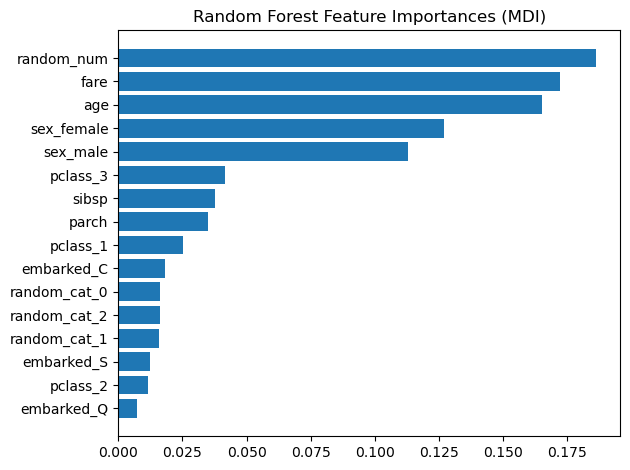

In [11]:
# 随机森林特征重要性官方实现参考：https://scikit-learn.org.cn/view/255.html（置换重要性与随机森林特征重要性(MDI)）
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)


print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))


ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names_out(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

Accuracy on test data: 0.97


/tmp/ipykernel_1249462/581508167.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
/tmp/ipykernel_1249462/581508167.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,


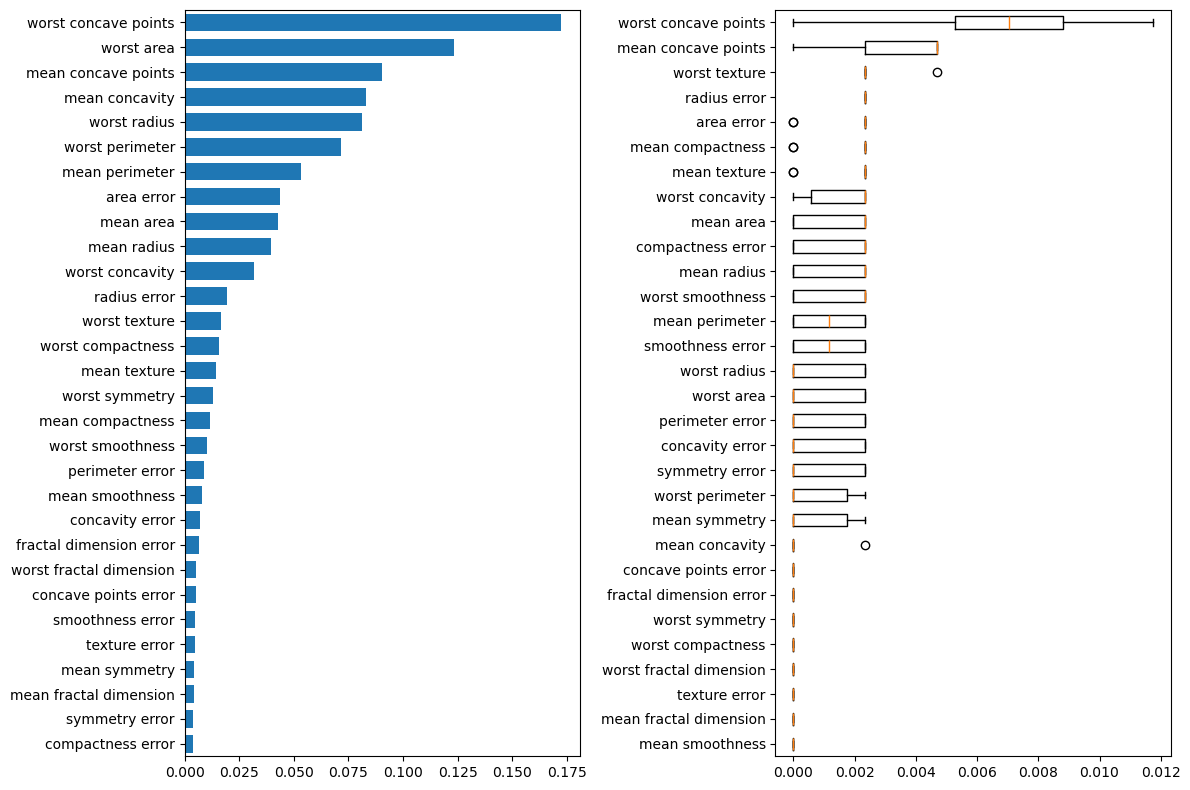

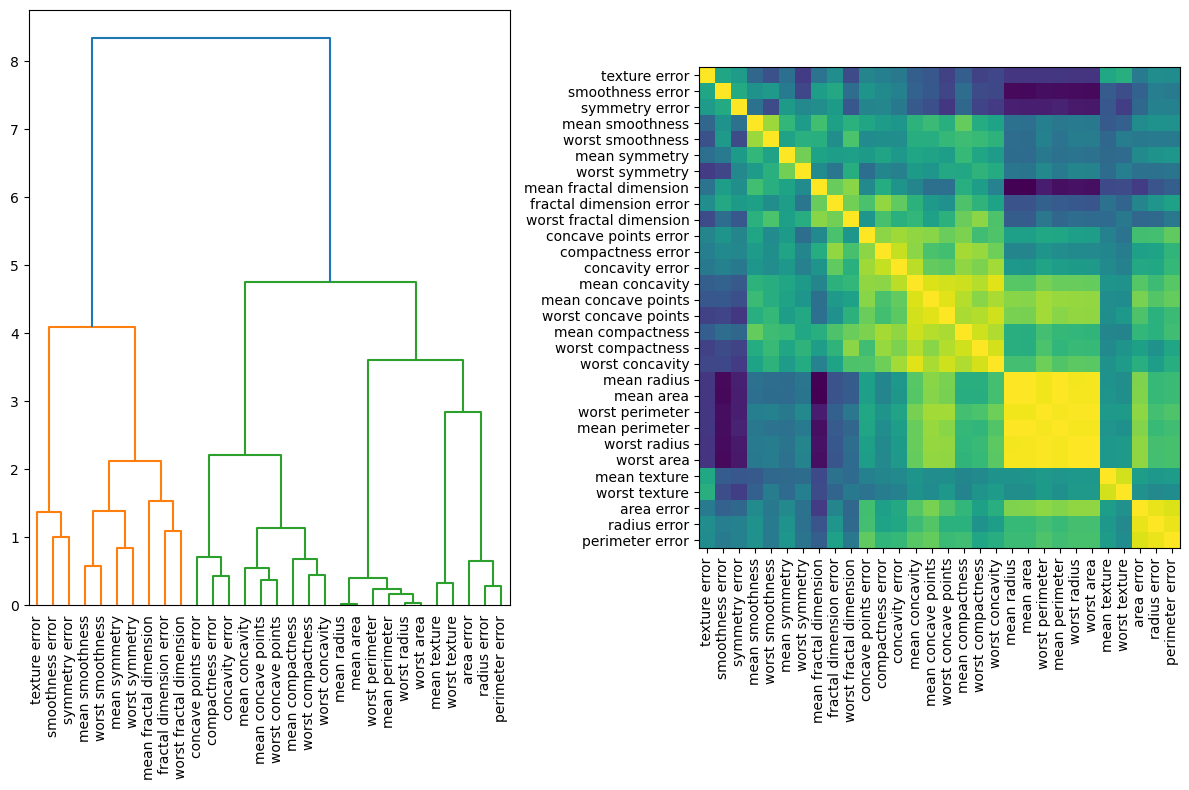

In [12]:
# 官方实现Spearman秩序相关性与置换重要性：https://scikit-learn.org.cn/view/254.html（具有多重共线性或相关特征的置换重要性）
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# 首先，在乳腺癌数据集上训练随机森林，并在测试集上评估其准确性：
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

# 其次，绘制基于树的特征重要性和置换重要性。
# 置换重要性图显示，变换一个特征最多降低了0.012的准确性，这意味着没有任何一个特征是重要的。
# 这与上面计算的高精度测试是矛盾的：某些特性必须是重要的。在训练集上计算置换的重要性，以显示模型在训练过程中对每个特征的依赖程度。
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

# 处理多线性特征
# 通过对Spearman秩序相关性执行分层聚类，选择一个阈值，并从每个聚类中保留一个特征
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=data.feature_names, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

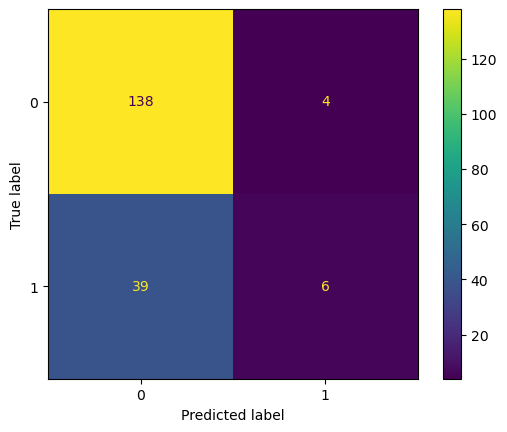

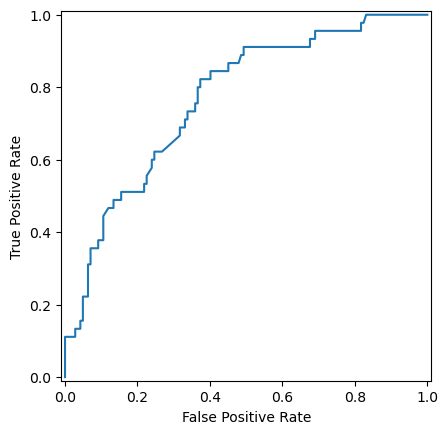

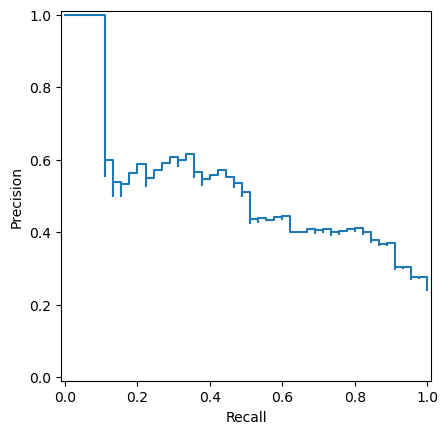

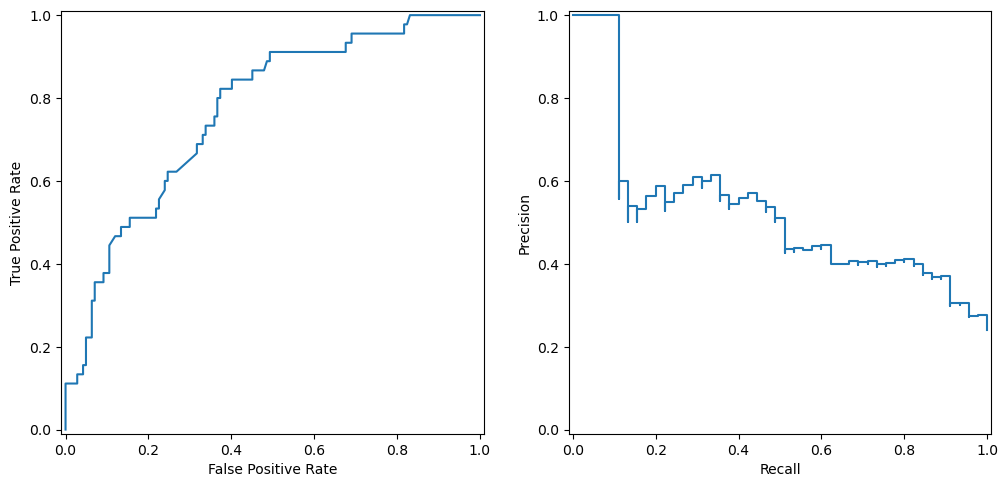

In [20]:
# 显示对象的可视化——构造混淆矩阵和ROC曲线https://scikit-learn.org.cn/view/273.html
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = fetch_openml(data_id=1464, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)

# 使用拟合的模型，我们可以在测试数据集上计算模型的预测。 这些预测用于计算使用ConfusionMatrixDisplay绘制的混淆矩阵。
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

# roc曲线需要估算器的概率或非阈值决策值。 由于逻辑回归提供了决策函数，因此我们将使用它来绘制roc曲线
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = clf.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# 使用预置部分中的y_score绘制精度召回曲线
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, y_score,
                                         pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()


# 将显示对象合并为一个图
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

# # 示例：绘制 SVM 的混淆矩阵官方实现：https://scikit-learn.org.cn/view/273.html
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay

# metrics_train = calculate_metrics(svm, X_train, y_train, label='SVM')
# cm_display = ConfusionMatrixDisplay(metrics_train['Confusion_Matrix']).plot()

/opt/anaconda3/envs/pl/lib/python3.10/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pl/lib/python3.10/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pl/lib/python3.10/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pl/lib/python3.10/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pl/lib/pytho

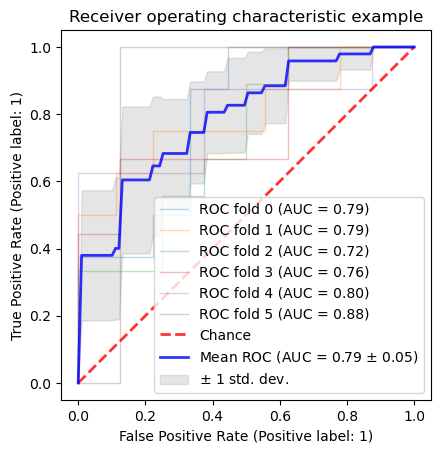

In [15]:
# 带交叉验证的ROC曲线https://scikit-learn.org.cn/view/289.html
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
# from sklearn.metrics import plot_roc_curve  # 旧版本代码，已移除
from sklearn.metrics import RocCurveDisplay   # 新版本导入方式
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# 获取数据

# 导入待处理的数据
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# 增加一些噪音特征
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# 分类，并使用ROC曲线分析结果

# 使用交叉验证运行分类器并绘制ROC曲线
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    # === 修改开始 ===
    # 旧代码: 
#     viz = plot_roc_curve(classifier, X[test], y[test],
#                          name='ROC fold {}'.format(i),
#                          alpha=0.3, lw=1, ax=ax)

    # 新代码: 使用 RocCurveDisplay.from_estimator
    viz = RocCurveDisplay.from_estimator(
        classifier, 
        X[test], 
        y[test],
        name='ROC fold {}'.format(i),
        alpha=0.3, 
        lw=1, 
        ax=ax
    )
    # === 修改结束 ===
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


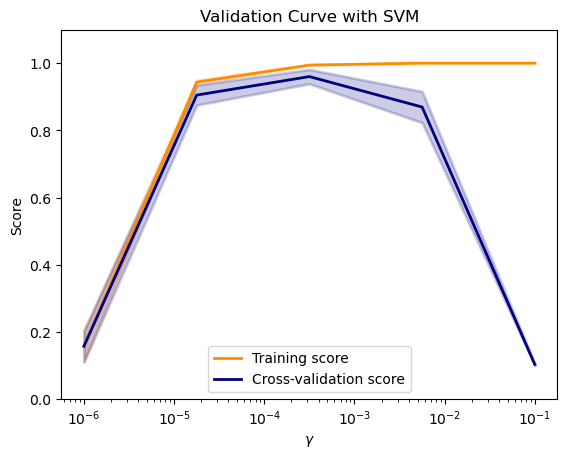

In [18]:
# 验证曲线：绘制分数以评估模型https://scikit-learn.org.cn/view/116.html#
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

X, y = load_digits(return_X_y=True)

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()